<h1>Notebook: RBM para Sistemas de Recomendación con MovieLens 1M</h1>

<h4>Configuración del Entorno<h4>

In [1]:
#Primero, importaremos las librerías necesarias y configuraremos el dispositivo (CPU o CUDA) para aprovechar la aceleración de hardware si está disponible.
# Importación de librerías necesarias
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.sparse as sp
from torch.utils.data import DataLoader, TensorDataset

# Configuración del dispositivo (CPU o CUDA)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")


Usando dispositivo: cuda


<h4>Carga y Preprocesamiento de los Datos<h4>

In [8]:
# Cargar las valoraciones desde el archivo 'ratings.dat'
ratings = pd.read_csv(
    'data/ml-1m/ratings.dat',
    sep='::',
    header=None,
    engine='python',
    names=['UserID', 'MovieID', 'Rating', 'Timestamp']
)


In [9]:
# Obtener el número único de usuarios y películas
nb_users = ratings['UserID'].nunique()
nb_movies = ratings['MovieID'].nunique()

print(f"Número de usuarios: {nb_users}")
print(f"Número de películas: {nb_movies}")


Número de usuarios: 6040
Número de películas: 3706


In [11]:
# Mapear MovieIDs a índices consecutivos
#Para facilitar el manejo de las películas en matrices, mapearemos cada MovieID a un índice consecutivo.
unique_movie_ids = ratings['MovieID'].unique()
movie_id_to_index = {movie_id: index for index, movie_id in enumerate(unique_movie_ids)}


In [12]:
#Cargaremos los datos de los usuarios, codificaremos las características categóricas (género, edad y ocupación) utilizando codificación one-hot, 
# y combinaremos todas las características en una matriz.
# Cargar los datos de usuarios desde el archivo 'users.dat'
users = pd.read_csv(
    'data/ml-1m/users.dat',
    sep='::',
    header=None,
    engine='python',
    names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
)

# Codificar género utilizando codificación one-hot
gender_dummies = pd.get_dummies(users['Gender'], prefix='Gender')

# Codificar edad utilizando codificación one-hot
age_dummies = pd.get_dummies(users['Age'], prefix='Age')

# Codificar ocupación utilizando codificación one-hot
occupation_dummies = pd.get_dummies(users['Occupation'], prefix='Occ')

# Combinar todas las características codificadas de los usuarios
user_features = pd.concat([gender_dummies, age_dummies, occupation_dummies], axis=1)

# Asegurar que UserID comienza desde 0
users['UserID'] = users['UserID'] - 1
user_features = user_features.values  # Convertir a array de NumPy

# Convertir las características de usuario a un tensor de PyTorch y enviarlo al dispositivo
user_features_tensor = torch.FloatTensor(user_features).to(device)
num_user_features = user_features.shape[1]

print(f"Número de características de usuario: {num_user_features}")


Número de características de usuario: 30


In [13]:
# Crear división de entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)


In [14]:
#Para manejar eficientemente grandes conjuntos de datos dispersos, utilizaremos matrices dispersas de SciPy 
# y luego las convertiremos a tensores densos de PyTorch.
def convert_optimized(data, nb_users, nb_movies, movie_id_to_index):
    """
    Convierte los datos en una matriz donde las filas representan usuarios
    y las columnas representan películas. Las valoraciones no observadas se asignan a 0.
    Utiliza una matriz dispersa para mayor eficiencia.

    Args:
        data (pd.DataFrame): DataFrame con las valoraciones.
        nb_users (int): Número total de usuarios.
        nb_movies (int): Número total de películas.
        movie_id_to_index (dict): Diccionario para mapear MovieID a índices.

    Returns:
        dense_matrix (torch.Tensor): Tensor denso con las valoraciones.
    """
    data = data.copy()
    data['UserID'] = data['UserID'] - 1  # Ajustar índices de usuarios
    data['MovieIndex'] = data['MovieID'].map(movie_id_to_index)

    # Filtrar entradas válidas
    data = data.dropna(subset=['MovieIndex'])
    data['MovieIndex'] = data['MovieIndex'].astype(int)

    # Construir la matriz dispersa
    rows = data['UserID'].astype(int)
    cols = data['MovieIndex']
    ratings = data['Rating']
    sparse_matrix = sp.coo_matrix((ratings, (rows, cols)), shape=(nb_users, nb_movies))

    # Convertir a tensor denso
    dense_matrix = torch.FloatTensor(sparse_matrix.toarray())

    return dense_matrix


In [15]:
# Convertir los datos de entrenamiento y prueba a tensores densos
training_set = convert_optimized(train_data, nb_users, nb_movies, movie_id_to_index)
test_set = convert_optimized(test_data, nb_users, nb_movies, movie_id_to_index)

In [16]:
#Para simplificar el modelo, binarizaremos las valoraciones: 1 para valoraciones >= 3, 0 para valoraciones 1-2, y -1 para valoraciones no observadas.
def binarize(tensor):
    """
    Binariza las valoraciones: 1 para valoraciones >= 3, 0 para valoraciones 1-2, -1 para no observadas.

    Args:
        tensor (torch.Tensor): Tensor con las valoraciones originales.

    Returns:
        tensor (torch.Tensor): Tensor binarizado.
    """
    tensor = tensor.clone()
    tensor[tensor == 0] = -1
    tensor[tensor == 1] = 0
    tensor[tensor == 2] = 0
    tensor[tensor >= 3] = 1
    return tensor

# Aplicar la binarización a los conjuntos de entrenamiento y prueba
training_set = binarize(training_set).to(device)
test_set = binarize(test_set).to(device)


In [17]:
# Concatenar características de usuario a las valoraciones
training_set = torch.cat((training_set, user_features_tensor), dim=1)
test_set = torch.cat((test_set, user_features_tensor), dim=1)

print(f"Dimensiones del conjunto de entrenamiento: {training_set.shape}")
print(f"Dimensiones del conjunto de prueba: {test_set.shape}")


Dimensiones del conjunto de entrenamiento: torch.Size([6040, 3736])
Dimensiones del conjunto de prueba: torch.Size([6040, 3736])


<h2>Definición de la Clase RBM</h2>

In [18]:
# Definición de la clase RBM

class RBM(nn.Module):
    """
    Máquina de Boltzmann Restringida (RBM) para sistemas de recomendación.

    Args:
        nv (int): Número de unidades visibles (valoraciones + características).
        nh (int): Número de unidades ocultas.
        device (torch.device): Dispositivo (CPU o CUDA).
        lr (float): Tasa de aprendizaje.

    Attributes:
        W (nn.Parameter): Matriz de pesos entre unidades visibles y ocultas.
        a (nn.Parameter): Sesgos de las unidades ocultas.
        b (nn.Parameter): Sesgos de las unidades visibles.
    """
    def __init__(self, nv, nh, device, lr=0.1):
        super(RBM, self).__init__()
        self.nv = nv  # Unidades visibles
        self.nh = nh  # Unidades ocultas
        self.device = device
        self.lr = lr

        # Inicializar parámetros
        self.W = nn.Parameter(torch.randn(nh, nv, device=device) * 0.01)
        self.a = nn.Parameter(torch.zeros(1, nh, device=device))
        self.b = nn.Parameter(torch.zeros(1, nv, device=device))

    def sample_h(self, x):
        """
        Muestrea las unidades ocultas dadas las visibles.

        Args:
            x (torch.Tensor): Unidades visibles.

        Returns:
            p_h_given_v (torch.Tensor): Probabilidad de activación de las unidades ocultas.
            h_sample (torch.Tensor): Muestras binarias de las unidades ocultas.
        """
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a
        p_h_given_v = torch.sigmoid(activation)
        h_sample = torch.bernoulli(p_h_given_v)
        return p_h_given_v, h_sample

    def sample_v(self, y):
        """
        Muestrea las unidades visibles dadas las ocultas.

        Args:
            y (torch.Tensor): Unidades ocultas.

        Returns:
            p_v_given_h (torch.Tensor): Probabilidad de activación de las unidades visibles.
            v_sample (torch.Tensor): Muestras binarias de las unidades visibles.
        """
        wy = torch.mm(y, self.W)
        activation = wy + self.b
        p_v_given_h = torch.sigmoid(activation)
        v_sample = torch.bernoulli(p_v_given_h)
        return p_v_given_h, v_sample

    def forward(self, v):
        """
        Define el paso forward (opcional para RBM).

        Args:
            v (torch.Tensor): Unidades visibles.

        Returns:
            None
        """
        pass

    def train_rbm(self, v0, vk, ph0, phk):
        """
        Realiza una actualización de los pesos y sesgos utilizando Contrastive Divergence.

        Args:
            v0 (torch.Tensor): Entrada original.
            vk (torch.Tensor): Entrada reconstruida después de k pasos de Gibbs.
            ph0 (torch.Tensor): Probabilidades de activación iniciales de las unidades ocultas.
            phk (torch.Tensor): Probabilidades de activación finales de las unidades ocultas.

        Returns:
            None
        """
        positive_grad = torch.mm(ph0.t(), v0)
        negative_grad = torch.mm(phk.t(), vk)

        # Asignar gradientes manualmente
        self.W.grad = -(positive_grad - negative_grad) / v0.size(0)
        self.b.grad = -torch.mean(v0 - vk, dim=0, keepdim=True)
        self.a.grad = -torch.mean(ph0 - phk, dim=0, keepdim=True)


<h2>Inicialización de la RBM y el Optimizador</h2>

In [19]:
# Definir hiperparámetros
nv = nb_movies + num_user_features  # Número de unidades visibles (valoraciones + características)
nh = 200        # Número de unidades ocultas (ajustable)
batch_size = 128  # Tamaño del batch (ajustable)
lr = 0.005       # Tasa de aprendizaje (ajustable)

# Inicializar la RBM
rbm = RBM(nv, nh, device, lr).to(device)

# Implementar regularización L2
weight_decay = 0.0001  # Coeficiente de regularización (ajustable)

# Definir el optimizador (SGD con regularización L2)
optimizer = optim.SGD(rbm.parameters(), lr=rbm.lr, weight_decay=weight_decay)


<h3>Preparación de los DataLoaders</h3>

In [20]:
# Crear TensorDatasets para entrenamiento y prueba
train_dataset = TensorDataset(training_set)
test_dataset = TensorDataset(test_set)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


<h1>Entrenamiento de la RBM<h1>

In [21]:
# Definir número de épocas
nb_epoch = 50
loss_per_epoch = []
test_loss_per_epoch = []

# Definir el número de columnas correspondientes a las valoraciones
num_visible_ratings = nb_movies  # Número de columnas de valoraciones

for epoch in range(1, nb_epoch + 1):
    rbm.train()
    training_loss = 0
    s = 0.
    
    for batch in train_loader:
        v0 = batch[0].to(device)  # Valoraciones originales + características de usuario
        vk = v0.clone()
        
        # Muestrear las unidades ocultas
        ph0, _ = rbm.sample_h(v0)
        
        # Contrastive Divergence con k=1
        for k in range(1):
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)
            # Mantener las características de usuario sin cambios
            vk[:, num_visible_ratings:] = v0[:, num_visible_ratings:]
            # Mantener las unidades visibles no observadas en su estado original usando torch.where
            vk[:, :num_visible_ratings] = torch.where(
                v0[:, :num_visible_ratings] < 0,
                v0[:, :num_visible_ratings],
                vk[:, :num_visible_ratings]
            )
        
        # Muestrear las unidades ocultas con las visibles reconstruidas
        phk, _ = rbm.sample_h(vk)
        
        # Zero grad
        optimizer.zero_grad()
        
        # Calcular y asignar los gradientes
        rbm.train_rbm(v0, vk, ph0, phk)
        
        # Actualizar parámetros
        optimizer.step()
        
        # Calcular la pérdida (Error absoluto medio)
        mask = v0[:, :num_visible_ratings] >= 0  # Solo considerar las valoraciones
        if mask.sum() > 0:
            loss_mae = torch.mean(torch.abs(v0[:, :num_visible_ratings][mask] - vk[:, :num_visible_ratings][mask])).item()
            training_loss += loss_mae
            s += 1.
    
    # Calcular la pérdida promedio de entrenamiento
    average_loss = training_loss / s if s > 0 else 0
    loss_per_epoch.append(average_loss)
    
    # Evaluación en el conjunto de prueba
    rbm.eval()
    testing_loss = 0
    s_test = 0.
    
    with torch.no_grad():
        for batch in test_loader:
            v = batch[0].to(device)
            vt = v.clone()
            _, h = rbm.sample_h(v)
            _, v_rec = rbm.sample_v(h)
            # Mantener las características de usuario sin cambios
            v_rec[:, num_visible_ratings:] = v[:, num_visible_ratings:]
            # Mantener las unidades visibles no observadas en su estado original usando torch.where
            v_rec[:, :num_visible_ratings] = torch.where(
                vt[:, :num_visible_ratings] < 0,
                vt[:, :num_visible_ratings],
                v_rec[:, :num_visible_ratings]
            )
            mask = vt[:, :num_visible_ratings] >= 0
            if mask.sum() > 0:
                loss_mae_test = torch.mean(torch.abs(vt[:, :num_visible_ratings][mask] - v_rec[:, :num_visible_ratings][mask])).item()
                testing_loss += loss_mae_test
                s_test += 1.
    
    # Calcular la pérdida promedio de prueba
    average_test_loss = testing_loss / s_test if s_test > 0 else 0
    test_loss_per_epoch.append(average_test_loss)
    
    # Imprimir resultados de la época
    print(f"Epoch: {epoch}, Loss MAE: {average_loss:.4f}, Test Loss MAE: {average_test_loss:.4f}")


Epoch: 1, Loss MAE: 0.4433, Test Loss MAE: 0.3997
Epoch: 2, Loss MAE: 0.3615, Test Loss MAE: 0.3572
Epoch: 3, Loss MAE: 0.3270, Test Loss MAE: 0.3395
Epoch: 4, Loss MAE: 0.3098, Test Loss MAE: 0.3234
Epoch: 5, Loss MAE: 0.2984, Test Loss MAE: 0.3182
Epoch: 6, Loss MAE: 0.2904, Test Loss MAE: 0.3079
Epoch: 7, Loss MAE: 0.2837, Test Loss MAE: 0.3056
Epoch: 8, Loss MAE: 0.2796, Test Loss MAE: 0.3005
Epoch: 9, Loss MAE: 0.2765, Test Loss MAE: 0.2990
Epoch: 10, Loss MAE: 0.2732, Test Loss MAE: 0.2964
Epoch: 11, Loss MAE: 0.2713, Test Loss MAE: 0.2934
Epoch: 12, Loss MAE: 0.2696, Test Loss MAE: 0.2893
Epoch: 13, Loss MAE: 0.2672, Test Loss MAE: 0.2879
Epoch: 14, Loss MAE: 0.2657, Test Loss MAE: 0.2870
Epoch: 15, Loss MAE: 0.2631, Test Loss MAE: 0.2854
Epoch: 16, Loss MAE: 0.2629, Test Loss MAE: 0.2855
Epoch: 17, Loss MAE: 0.2617, Test Loss MAE: 0.2832
Epoch: 18, Loss MAE: 0.2602, Test Loss MAE: 0.2845
Epoch: 19, Loss MAE: 0.2589, Test Loss MAE: 0.2815
Epoch: 20, Loss MAE: 0.2591, Test Loss M

<h2>Visualización de la Pérdida</h2>

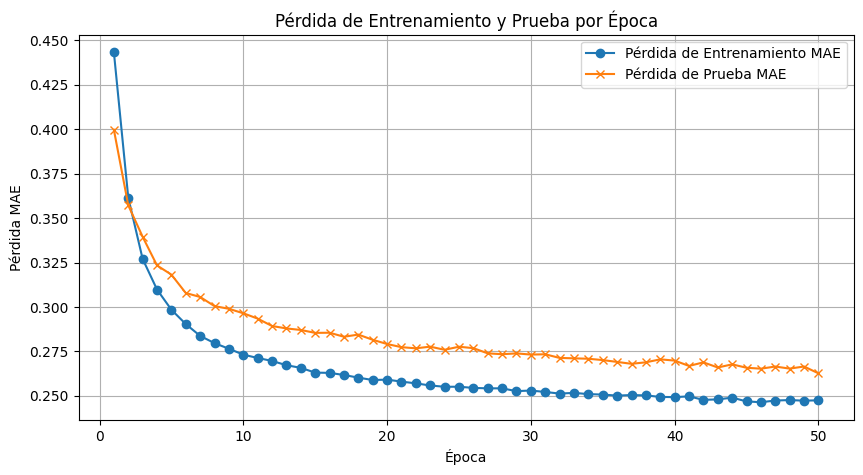

In [22]:
# Visualizar la pérdida de entrenamiento y prueba por época
plt.figure(figsize=(10,5))
plt.plot(range(1, nb_epoch + 1), loss_per_epoch, marker='o', label='Pérdida de Entrenamiento MAE')
plt.plot(range(1, nb_epoch + 1), test_loss_per_epoch, marker='x', label='Pérdida de Prueba MAE')
plt.xlabel('Época')
plt.ylabel('Pérdida MAE')
plt.title('Pérdida de Entrenamiento y Prueba por Época')
plt.legend()
plt.grid(True)
plt.show()
